In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()

from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from tqdm import tqdm_notebook as tqdm

from joblib import Parallel, delayed

In [2]:
def generate_2d_rotation(theta=0, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
    
    R = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])
    
    return R


def generate_gaussian_parity(n, mean=np.array([-1, -1]), cov_scale=1, angle_params=None, k=1, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    d = len(mean)
    
    if mean[0] == -1 and mean[1] == -1:
        mean = mean + 1 / 2**k
    
    mnt = np.random.multinomial(n, 1/(4**k) * np.ones(4**k))
    cumsum = np.cumsum(mnt)
    cumsum = np.concatenate(([0], cumsum))
    
    Y = np.zeros(n)
    X = np.zeros((n, d))
    
    for i in range(2**k):
        for j in range(2**k):
            temp = np.random.multivariate_normal(mean, cov_scale * np.eye(d), 
                                                 size=mnt[i*(2**k) + j])
            temp[:, 0] += i*(1/2**(k-1))
            temp[:, 1] += j*(1/2**(k-1))
            
            X[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = temp
            
            if i % 2 == j % 2:
                Y[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = 0
            else:
                Y[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = 1
                
    if d == 2:
        if angle_params is None:
            angle_params = np.random.uniform(0, 2*np.pi)
            
        R = generate_2d_rotation(angle_params)
        X = X @ R
        
    else:
        raise ValueError('d=%i not implemented!'%(d))
       
    return X, Y.astype(int)


def generate_spirals(N, D=2, K=5, noise = 0.5, acorn = None, density=0.3):

    #N number of poinst per class
    #D number of features, 
    #K number of classes
    X = []
    Y = []
    if acorn is not None:
        np.random.seed(acorn)
    
    if K == 2:
        turns = 2
    elif K==3:
        turns = 2.5
    elif K==5:
        turns = 3.5
    elif K==7:
        turns = 4.5
    else:
        print ("sorry, can't currently surpport %s classes " %K)
        return
    
    mvt = np.random.multinomial(N, 1/K * np.ones(K))
    
    if K == 2:
#         r = np.linspace(0.01, 1, N)
        r = np.random.uniform(0,1,size=int(N/K))
        r = np.sort(r)
        t = np.linspace(0,  np.pi* 4 * turns/K, int(N/K)) + noise * np.random.normal(0, density, int(N/K))
        dx = r * np.cos(t)
        dy = r* np.sin(t)

        X.append(np.vstack([dx, dy]).T )
        X.append(np.vstack([-dx, -dy]).T)
        Y += [0] * int(N/K) 
        Y += [1] * int(N/K)
    else:    
        for j in range(1, K+1):
            r = np.linspace(0.01, 1, int(mvt[j-1]))
            t = np.linspace((j-1) * np.pi *4 *turns/K,  j* np.pi * 4* turns/K, int(mvt[j-1])) + noise * np.random.normal(0, density, int(mvt[j-1]))
            dx = r * np.cos(t)
            dy = r* np.sin(t)

            dd = np.vstack([dx, dy]).T        
            X.append(dd)
            #label
            Y += [j-1] * int(mvt[j-1])
    return np.vstack(X), np.array(Y).astype(int)


def get_colors(colors, inds):
    c = [colors[i] for i in inds]
    return c

In [3]:
# Capacity controlled
n_mc = 500 # number of simulation repititions

h=0.5

n_xor = (100*np.arange(0.5, 2+h, step=+h)).astype(int)
n_nxor = (100*np.arange(0.5, 10+h, step=+h)).astype(int) # number of training samples 

m = 1000 # number of test samples each monte carlo iteration

nR=1

d = 2

n1s = n_xor
n2s = n_nxor

ns = np.concatenate((n1s, n2s + n1s[-1]))

ls=['-', '--']
algorithms = ['Uncertainty Forest', 'Lifelong Forest']

In [4]:
import pickle 

TASK1='XOR'
TASK2='N-XOR'
mean_error_xor_nxor = pickle.load(open('/data/Jayanta/lifelong-learning/cef/data/gaussian-lifelong-experiments/mean_error_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'rb'))

std_error_xor_nxor = pickle.load(open('/data/Jayanta/lifelong-learning/cef/data/gaussian-lifelong-experiments/std_error_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'rb'))

mean_te_xor_nxor = pickle.load(open('/data/Jayanta/lifelong-learning/cef/data/gaussian-lifelong-experiments/mean_te_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'rb'))

std_te_xor_nxor = pickle.load(open('/data/Jayanta/lifelong-learning/cef/data/gaussian-lifelong-experiments/std_te_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'rb'))

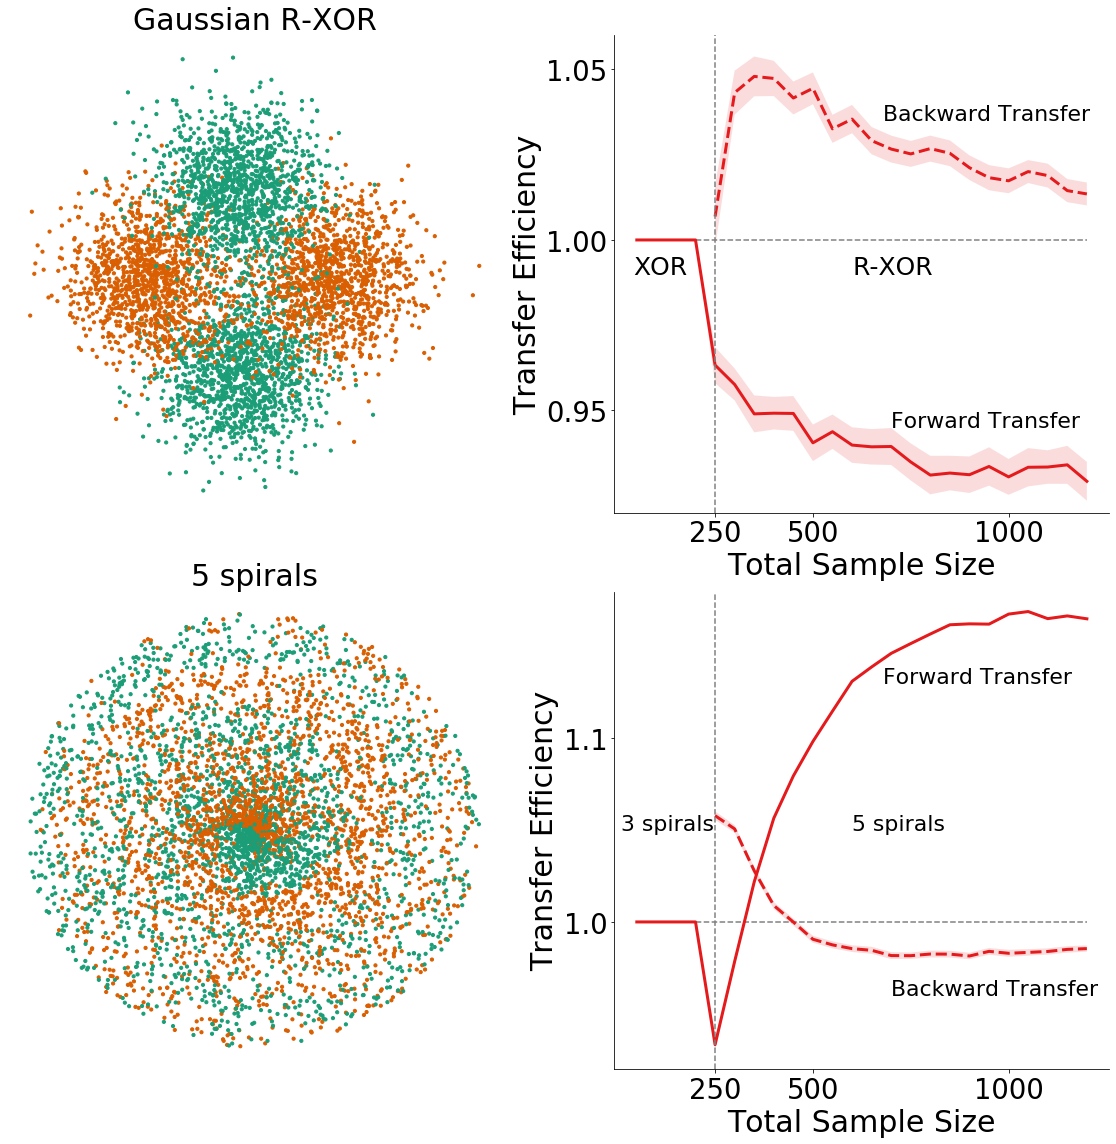

In [33]:
#sns.set()

fontsize=30
labelsize=27.5

colors = sns.color_palette('Dark2', n_colors=2)

X, Y = generate_gaussian_parity(5000, cov_scale=0.1, angle_params=0)
Z, W = generate_gaussian_parity(5000, cov_scale=0.1, angle_params=np.pi/4)

fig, ax = plt.subplots(2,2, figsize=(16,16))

ax[0][0].scatter(Z[:, 0], Z[:, 1], c=get_colors(colors, W), s=10)

ax[0][0].set_xticks([])
ax[0][0].set_yticks([])
ax[0][0].set_title('Gaussian R-XOR', fontsize=30)
ax[0][0].axis('off')




# ax.set_aspect('equal')
TASK1='XOR'
TASK2='R-XOR'
mean_error_xor_rxor = pickle.load(open('/data/Jayanta/lifelong-learning/cef/data/gaussian-lifelong-experiments/mean_error_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'rb'))

std_error_xor_rxor = pickle.load(open('/data/Jayanta/lifelong-learning/cef/data/gaussian-lifelong-experiments/std_error_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'rb'))

mean_te_xor_rxor = pickle.load(open('/data/Jayanta/lifelong-learning/cef/data/gaussian-lifelong-experiments/mean_te_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'rb'))

std_te_xor_rxor = pickle.load(open('/data/Jayanta/lifelong-learning/cef/data/gaussian-lifelong-experiments/std_te_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'rb'))

mean_error = mean_te_xor_rxor
std_error = std_te_xor_rxor / np.sqrt(n_mc)

TASK1='XOR'
TASK2='R-XOR'

colors = sns.color_palette("Set1", n_colors = 2)


ax[0][1].plot(ns, mean_error[0], label='Forard Transfer', c=colors[0], ls=ls[0], lw=3)
ax[0][1].fill_between(ns, 
        mean_error[0] + 1.96*std_error[0], 
        mean_error[0] - 1.96*std_error[0], 
        where=mean_error[1] + 1.96*std_error[0] >= mean_error[0] - 1.96*std_error[0], 
        facecolor=colors[0], 
        alpha=0.15,
        interpolate=True)

ax[0][1].plot(ns[len(n1s):], mean_error[1, len(n1s):], label='Backward Transfer', c=colors[0], ls=ls[1], lw=3)
ax[0][1].fill_between(ns[len(n1s):], 
        mean_error[1, len(n1s):] + 1.96*std_error[1, len(n1s):], 
        mean_error[1, len(n1s):] - 1.96*std_error[1, len(n1s):], 
        where=mean_error[1, len(n1s):] + 1.96*std_error[1, len(n1s):] >= mean_error[1, len(n1s):] - 1.96*std_error[1, len(n1s):], 
        facecolor=colors[0], 
        alpha=0.15,
        interpolate=True)

ax[0][1].set_ylabel('Transfer Efficiency', fontsize=fontsize)
#ax[0][1].legend(loc='upper right', fontsize=22.5)
ax[0][1].set_ylim(0.92, 1.06)
ax[0][1].set_xlabel('Total Sample Size', fontsize=fontsize)
ax[0][1].tick_params(labelsize=labelsize)
ax[0][1].set_yticks([0.95, 1, 1.05])
ax[0][1].set_xticks([250, 500, 1000])
ax[0][1].axvline(x=ns[len(n1s)], c='grey', linestyle='dashed', linewidth=1.5)
ax[0][1].hlines(1, 100,1200, colors='grey', linestyle='dashed', linewidth=1.5)

ax[0][1].text(40, np.mean(ax[0][1].get_ylim()), "%s"%(TASK1), fontsize=25)
ax[0][1].text(600, np.mean(ax[0][1].get_ylim()), "%s"%(TASK2), fontsize=25)
right_side = ax[0][1].spines["right"]
right_side.set_visible(False)
top_side = ax[0][1].spines["top"]
top_side.set_visible(False)
ax[0][1].text(700, np.mean(ax[0][1].get_ylim())-.045, "Forward Transfer", fontsize=22)
ax[0][1].text(680, np.mean(ax[0][1].get_ylim())+.045, "Backward Transfer", fontsize=22)

colors = sns.color_palette('Dark2', n_colors=5)
Z, W = generate_spirals(5000, 2, 5, noise = 2.5)

ax[1][0].scatter(Z[:, 0], Z[:, 1], c=get_colors(colors, Y), s=10)

ax[1][0].set_xticks([])
ax[1][0].set_yticks([])
ax[1][0].set_title('5 spirals', fontsize=30)
ax[1][0].axis('off')



import pickle
TASK1='3 spirals'
TASK2='5 spirals'
mean_error_cb_xor = pickle.load(open('/data/Jayanta/lifelong-learning/cef/data/gaussian-lifelong-experiments/mean_error_Spiral3_Spiral5_nmc500_nD1_n150to200_n250to1000_d2_m1000.pkl', 
                                      'rb'))

std_error_cb_xor = pickle.load(open('/data/Jayanta/lifelong-learning/cef/data/gaussian-lifelong-experiments/mean_te_Spiral3_Spiral5_nmc500_nD1_n150to200_n250to1000_d2_m1000.pkl', 
                                      'rb'))

mean_te_cb_xor = pickle.load(open('/data/Jayanta/lifelong-learning/cef/data/gaussian-lifelong-experiments/mean_te_Spiral3_Spiral5_nmc500_nD1_n150to200_n250to1000_d2_m1000.pkl', 
                                      'rb'))

std_te_cb_xor = pickle.load(open('/data/Jayanta/lifelong-learning/cef/data/gaussian-lifelong-experiments/std_te_Spiral3_Spiral5_nmc500_nD1_n150to200_n250to1000_d2_m1000.pkl', 
                                      'rb'))




mean_error = mean_te_cb_xor
std_error = std_te_cb_xor / np.sqrt(n_mc)

colors = sns.color_palette("Set1", n_colors = 2)

fontsize=30
labelsize=27.5


ax[1][1].plot(ns, mean_error[0], label='Forard Transfer', c=colors[0], ls=ls[np.sum(0 > 1).astype(int)], lw=3)
ax[1][1].fill_between(ns, 
        mean_error[0] + 1.96*std_error[0], 
        mean_error[0] - 1.96*std_error[0], 
        where=mean_error[1] + 1.96*std_error[0] >= mean_error[0] - 1.96*std_error[0], 
        facecolor=colors[0], 
        alpha=0.15,
        interpolate=True)

ax[1][1].plot(ns[len(n1s):], mean_error[1, len(n1s):], label='Backward Transfer', c=colors[0], ls=ls[1], lw=3)
ax[1][1].fill_between(ns[len(n1s):], 
        mean_error[1, len(n1s):] + 1.96*std_error[1, len(n1s):], 
        mean_error[1, len(n1s):] - 1.96*std_error[1, len(n1s):], 
        where=mean_error[1, len(n1s):] + 1.96*std_error[1, len(n1s):] >= mean_error[1, len(n1s):] - 1.96*std_error[1, len(n1s):], 
        facecolor=colors[0], 
        alpha=0.15,
        interpolate=True)

ax[1][1].set_ylabel('Transfer Efficiency', fontsize=fontsize)
#ax[1][1].legend(loc='upper right', fontsize=22.5)
#         ax1.set_ylim(-0.01, 0.22)
ax[1][1].set_xlabel('Total Sample Size', fontsize=fontsize)
ax[1][1].tick_params(labelsize=labelsize)
ax[1][1].set_ylim(0.92, 1.18)
ax[1][1].set_yticks([1, 1.1])
ax[1][1].set_xticks([250, 500, 1000])
ax[1][1].axvline(x=ns[len(n1s)], c='grey', linestyle='dashed', linewidth=1.5)

# ax1.set_ylim(0.99, 1.061)

ax[1][1].text(10,  np.mean(ax[1][1].get_ylim()), "%s"%(TASK1), fontsize=22)
ax[1][1].text(600,  np.mean(ax[1][1].get_ylim()), "%s"%(TASK2), fontsize=22)

ax[1][1].hlines(1, 100,1200, colors='grey', linestyle='dashed', linewidth=1.5)
right_side = ax[1][1].spines["right"]
right_side.set_visible(False)
top_side = ax[1][1].spines["top"]
top_side.set_visible(False)
ax[1][1].text(700, np.mean(ax[1][1].get_ylim())-.09, "Backward Transfer", fontsize=22)
ax[1][1].text(680, np.mean(ax[1][1].get_ylim())+.08, "Forward Transfer", fontsize=22)

plt.tight_layout()
plt.savefig('/data/Jayanta/fig3.pdf',dpi=500)